In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import os
import re

# === PATHS ===
BASE_PATH = "data"  # folder containing data files

# Professor data
DATA_FILE_PROF   = os.path.join(BASE_PATH, "001MoDe_R1.csv")
MARKER_FILE_PROF = os.path.join(BASE_PATH, "001MoDe_R1.marker.csv")

# Own data (MouseReMoCo export)
MY_DATA_FILE     = os.path.join(BASE_PATH, "data.csv")
MY_MARKER_FILE   = os.path.join(BASE_PATH, "marker.csv")

# === CONSTANTS (from professor header) ===
SCREEN_WIDTH  = 1104
SCREEN_HEIGHT = 661
CORNER_X      = 302
CORNER_Y      = 80
CENTER_X      = 552
CENTER_Y      = 330
TASK_RADIUS   = 209.5
TASK_TOL      = 47.0   # taskTolerance (pixels)
PI            = math.pi

In [2]:
def parse_header_line(line):
    """
    Parse the header line 'key value;key value;...' into a dict.
    """
    meta = {}
    for part in line.split(";"):
        part = part.strip()
        if not part:
            continue
        if " " in part:
            key, val = part.split(" ", 1)
            meta[key] = val.strip()
    return meta


def load_kinematic_data(path):
    """
    Loads kinematic data from CSV:

    line 1: metadata
    line 2: date
    line 3: blank
    line 4: column names
    line 5+: timestamp,mouseX,mouseY,mouseInTarget
    """
    with open(path, "r", encoding="utf-8") as f:
        header_line = f.readline().strip()
        _ = f.readline()  # date
        _ = f.readline()  # blank
        _ = f.readline()  # "timestamp,mouseX,mouseY,mouseInTarget"

    meta = parse_header_line(header_line)

    data = np.loadtxt(path, delimiter=",", skiprows=4)
    # Remove any trailing zero rows (0,0,0,0)
    data = data[data[:, 0] > 0]

    ts_ms  = data[:, 0]
    x_scr  = data[:, 1]
    y_scr  = data[:, 2]
    inside = data[:, 3].astype(int)

    return ts_ms, x_scr, y_scr, inside, meta

In [3]:
def load_record_markers(marker_file):
    """
    Reads the marker CSV and extracts DoRecord (start) and DoPause (end).
    Stops when the summary table ('Var , nLaps , ...') begins.
    """
    starts = []
    ends   = []

    with open(marker_file, "r", encoding="utf-8") as f:
        _ = f.readline()  # header
        _ = f.readline()  # date
        _ = f.readline()  # blank

        reader = csv.reader(f)
        for row in reader:
            if len(row) > 0 and "Var" in row[0]:
                break
            if len(row) < 3:
                continue

            msg = row[2]
            try:
                ts_ms = float(row[1])
            except:
                continue

            if "DoCycleChange:DoRecord" in msg:
                starts.append(int(ts_ms))
            elif "DoCycleChange:DoPause" in msg:
                ends.append(int(ts_ms))

    return starts, ends


def get_record_indices(ts_ms, starts, ends):
    """
    Convert record start/end timestamps to index ranges into ts_ms.
    """
    ranges = []
    for s, e in zip(starts, ends):
        si = np.searchsorted(ts_ms, s, side="left")
        ei = np.searchsorted(ts_ms, e, side="right")
        ranges.append((si, ei))
    return ranges


# --- Load professor data + markers and get record ranges ---
ts_ms_prof, x_scr_prof, y_scr_prof, inside_prof, meta_prof = load_kinematic_data(DATA_FILE_PROF)
starts_prof, ends_prof = load_record_markers(MARKER_FILE_PROF)
record_ranges_prof = get_record_indices(ts_ms_prof, starts_prof, ends_prof)

print("Professor data – number of records found:", len(record_ranges_prof))
print("Index ranges:", record_ranges_prof)


Professor data – number of records found: 5
Index ranges: [(np.int64(1), np.int64(3972)), (np.int64(3972), np.int64(7870)), (np.int64(7870), np.int64(11768)), (np.int64(11768), np.int64(15652)), (np.int64(15652), np.int64(19588))]


In [4]:
def extract_record(ts_ms, x_scr, y_scr, inside_all, s_idx, e_idx):
    """
    Returns:
    - t_s    : seconds from record start
    - x_rel  : X relative to center (pixels)
    - y_rel  : Y relative to center (pixels, Y inverted like in assignment)
    - inside : inside target flag
    - x_scr, y_scr : original screen coordinates
    """
    ts  = ts_ms[s_idx:e_idx]
    xs  = x_scr[s_idx:e_idx]
    ys  = y_scr[s_idx:e_idx]
    ins = inside_all[s_idx:e_idx]

    # time in seconds (relative)
    t_s = (ts - ts[0]) / 1000.0

    # relative positions
    x_rel = xs - CENTER_X
    # Important: invert Y so that "up" is positive in relative coordinates
    y_rel = -(ys - CENTER_Y)

    return t_s, x_rel, y_rel, ins, xs, ys

In [5]:
def plot_trajectory(rec_id, x_rel, y_rel, inside):
    plt.figure(figsize=(6, 6))

    # Target circle in relative coordinates
    theta = np.linspace(0, 2 * PI, 400)
    cx = TASK_RADIUS * np.cos(theta)
    cy = TASK_RADIUS * np.sin(theta)
    plt.plot(cx, cy, color="yellow", linewidth=3, label="target circle")

    # Separate inside/outside
    inside_mask  = (inside == 1)
    outside_mask = (inside == 0)

    plt.scatter(x_rel[inside_mask],  y_rel[inside_mask],  s=2, c="green", label="inside")
    plt.scatter(x_rel[outside_mask], y_rel[outside_mask], s=2, c="red",   label="outside")

    plt.axhline(0, color="lightgray", linewidth=0.5)
    plt.axvline(0, color="lightgray", linewidth=0.5)

    plt.title(f"record {rec_id} – trajectory")
    plt.xlabel("X relative (pixels)")
    plt.ylabel("Y relative (pixels)")
    plt.gca().set_aspect("equal", "box")
    plt.legend()
    plt.grid(False)
    plt.show()

In [6]:
def plot_time_series(rec_id, t_s, x_rel, y_rel, inside):
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    # X(t)
    axs[0].plot(t_s, x_rel, ".", markersize=2, label="x_rel")
    axs[0].set_ylabel("X rel (px)")
    axs[0].legend()
    axs[0].grid(True)

    # Y(t)
    axs[1].plot(t_s, y_rel, ".", markersize=2, color="orange", label="y_rel")
    axs[1].set_ylabel("Y rel (px)")
    axs[1].legend()
    axs[1].grid(True)

    # inside(t)
    axs[2].step(t_s, inside, where="post", color="green", label="inside")
    axs[2].set_ylabel("inside")
    axs[2].set_xlabel("Time (s)")
    axs[2].set_ylim(-0.1, 1.1)
    axs[2].legend()
    axs[2].grid(True)

    fig.suptitle(f"record {rec_id} — time series", y=0.98)
    plt.tight_layout()
    plt.show()

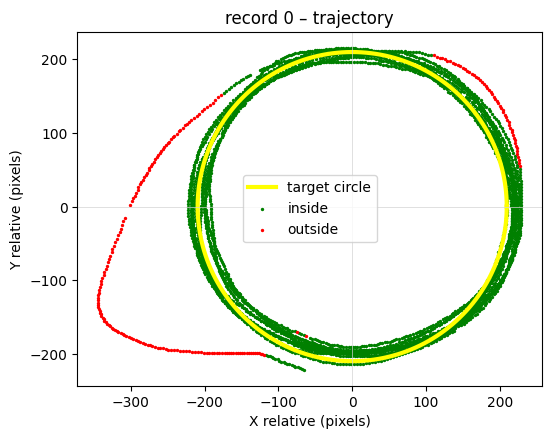

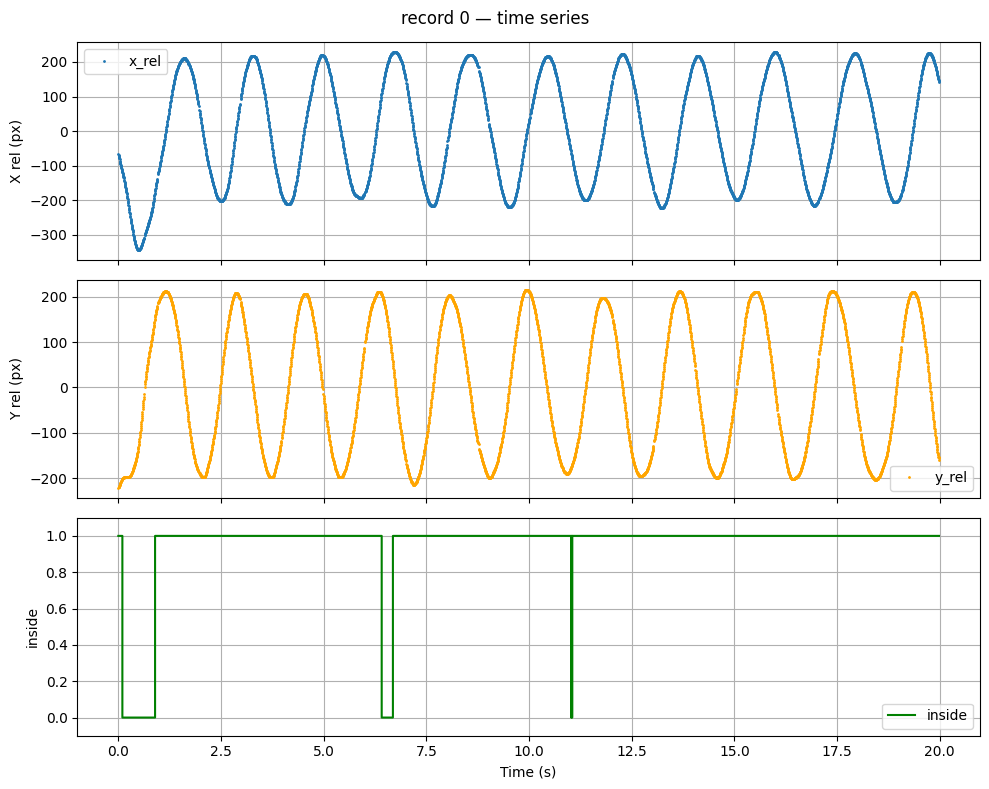

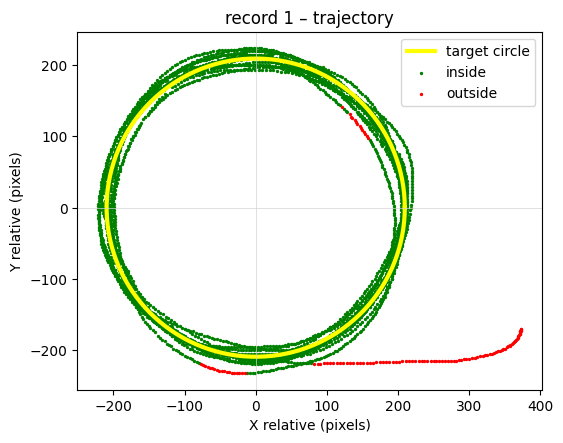

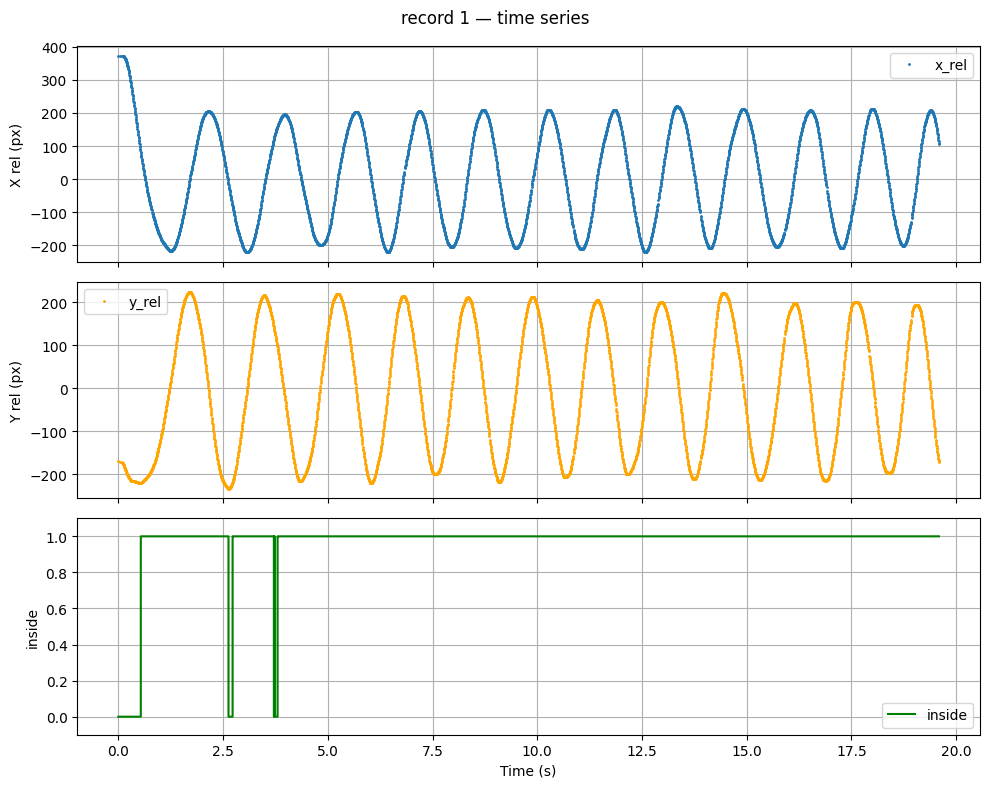

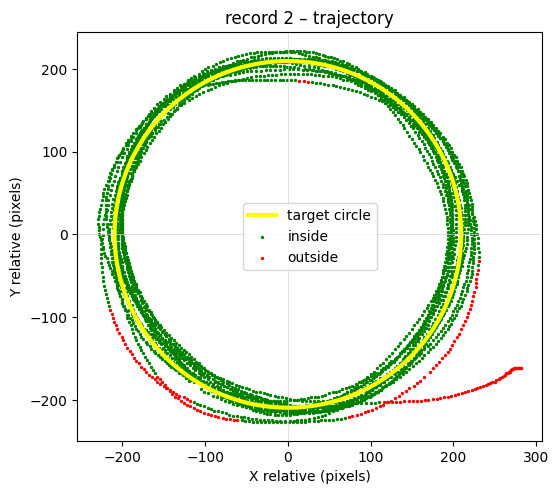

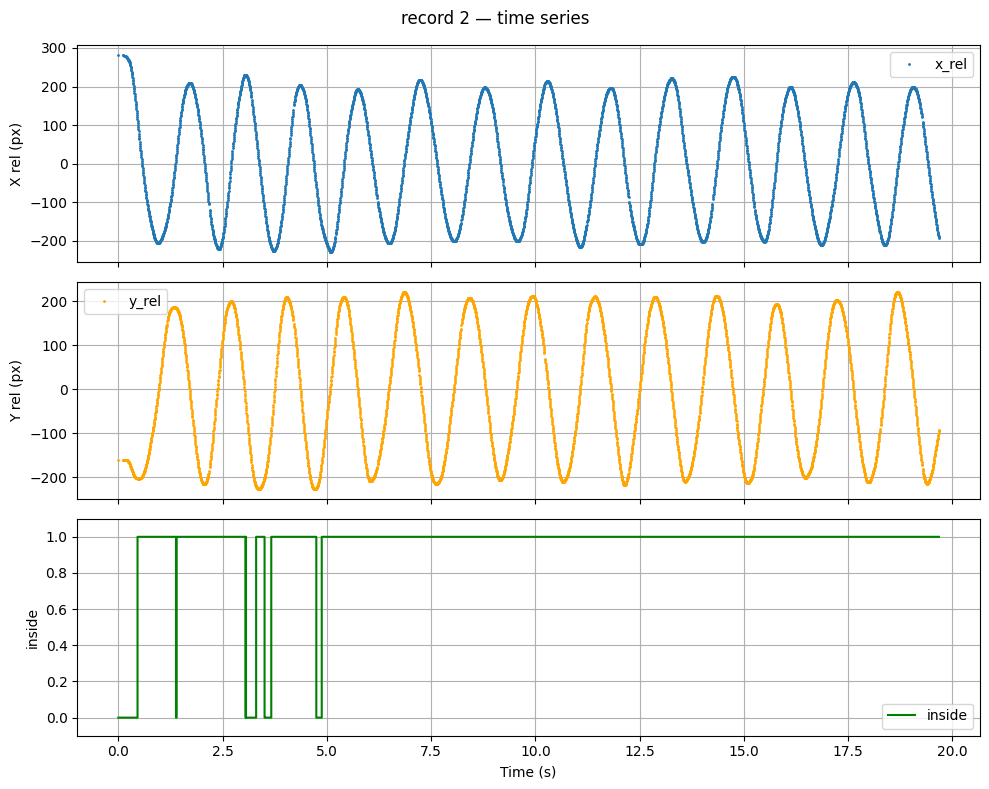

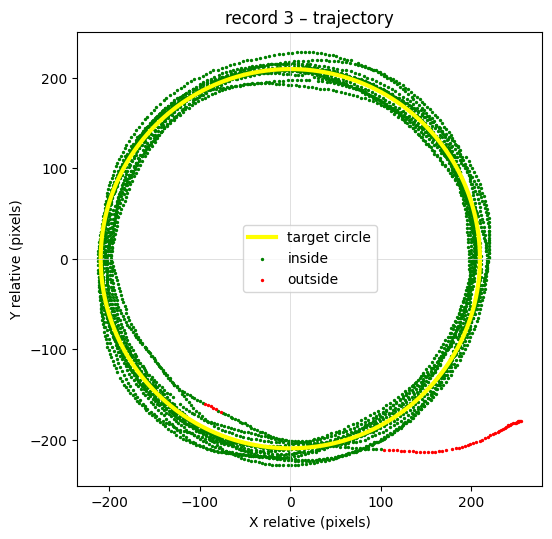

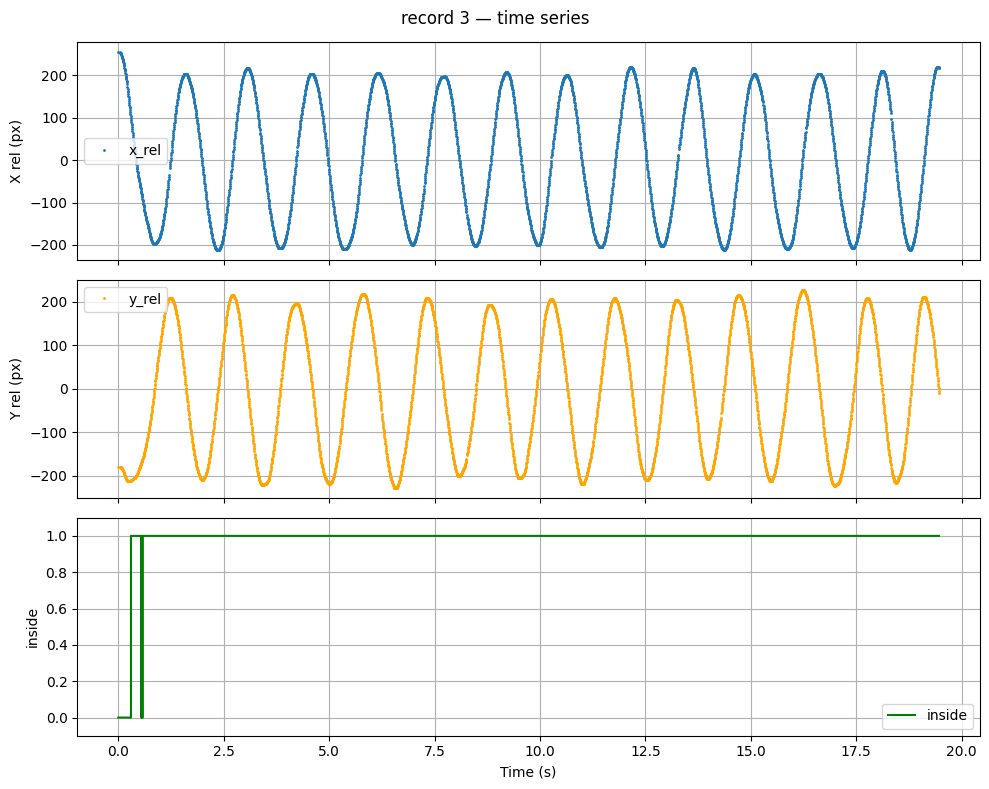

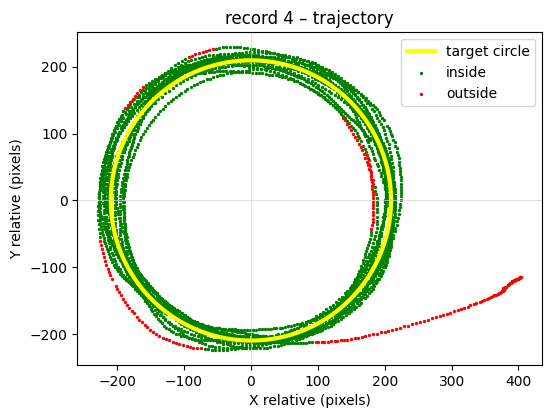

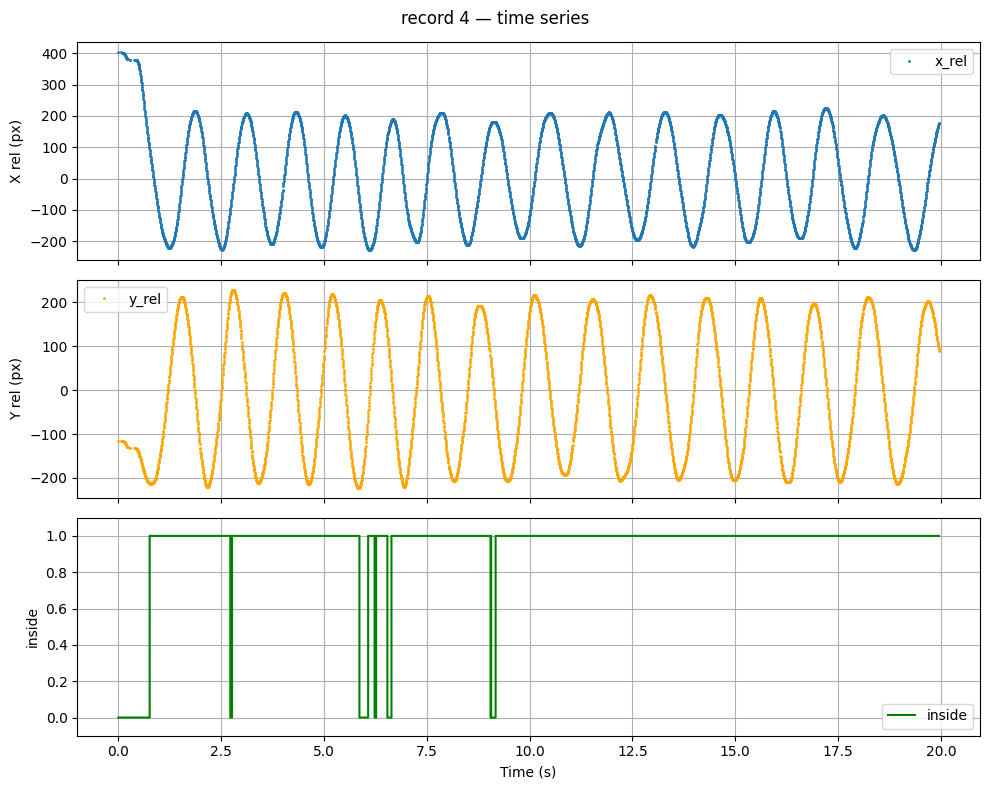

In [7]:
# Plot records 0–4 (Rec001–Rec005 in the marker file)
for rec_id in range(5):
    s_idx, e_idx = record_ranges_prof[rec_id]

    t_s, x_rel, y_rel, inside, xs, ys = extract_record(
        ts_ms_prof, x_scr_prof, y_scr_prof, inside_prof, s_idx, e_idx
    )

    plot_trajectory(rec_id, x_rel, y_rel, inside)
    plot_time_series(rec_id, t_s, x_rel, y_rel, inside)

In [8]:
def compute_metrics_for_record(ts_ms, x_scr, y_scr, inside, s_idx, e_idx):
    """
    Compute metrics for one record, in the spirit of the professor's table.

    Returns a dict with:
    nLaps, Re, Te, error%, MT_lap, IDe_lap, Be, IPe
    """
    ts  = ts_ms[s_idx:e_idx]
    xs  = x_scr[s_idx:e_idx]
    ys  = y_scr[s_idx:e_idx]
    ins = inside[s_idx:e_idx]

    # time in seconds (relative)
    t_s = (ts - ts[0]) / 1000.0

    # Relative coordinates (same as for plotting)
    x_rel = xs - CENTER_X
    y_rel = -(ys - CENTER_Y)

    # ----- nLaps from angle (on-target points only) -----
    on_mask = (ins == 1)
    theta   = np.unwrap(np.arctan2(y_rel[on_mask], x_rel[on_mask]))
    nLaps   = (theta[-1] - theta[0]) / (2 * PI)

    # Make the sign match professor: they used negative for clockwise
    nLaps_signed = -nLaps

    # ----- Radius, Re, Te (use ALL points here) -----
    R_all = np.sqrt(x_rel**2 + y_rel**2)
    Re    = float(np.mean(R_all))

    sd_R  = float(np.std(R_all, ddof=1)) if len(R_all) > 1 else 0.0
    Te    = 4.133 * sd_R   # effective band width

    # ----- MT/lap -----
    T_total = float(t_s[-1] - t_s[0])  # total time (s)
    MT_lap  = T_total / abs(nLaps) if abs(nLaps) > 1e-9 else math.nan

    # ----- IDe/lap (information per lap) -----
    IDe_lap = (2 * PI * Re) / Te if Te > 1e-9 else math.nan

    # ----- error% (simple off-target proportion) -----
    off_prop = float((ins == 0).sum()) / float(len(ins))
    error_pct = off_prop * 100.0

    # ----- Be & IPe -----
    Be  = Te / TASK_TOL if TASK_TOL > 0 else math.nan
    IPe = IDe_lap / MT_lap if MT_lap > 0 else math.nan

    return {
        "nLaps":   nLaps_signed,
        "Re":      Re,
        "Te":      Te,
        "error%":  error_pct,
        "MT_lap":  MT_lap,
        "IDe_lap": IDe_lap,
        "Be":      Be,
        "IPe":     IPe,
    }


# --- Recompute table for Given data ---
print("Recomputed metrics for Given data:\n")
print("   Var ,   nLaps ,    Re ,    Te , error , MT/lap , IDe/lap ,   Be ,  IPe")

for i, (s_idx, e_idx) in enumerate(record_ranges_prof, start=1):
    m = compute_metrics_for_record(ts_ms_prof, x_scr_prof, y_scr_prof, inside_prof, s_idx, e_idx)
    print(
        f"Rec{i:03d} , "
        f"{m['nLaps']:6.2f} , "
        f"{m['Re']:7.2f} , "
        f"{m['Te']:7.2f} , "
        f"{m['error%']:6.2f} , "
        f"{m['MT_lap']:7.2f} , "
        f"{m['IDe_lap']:7.2f} , "
        f"{m['Be']:5.2f} , "
        f"{m['IPe']:5.2f}"
    )

Recomputed metrics for Given data:

   Var ,   nLaps ,    Re ,    Te , error , MT/lap , IDe/lap ,   Be ,  IPe
Rec001 ,  10.84 ,  213.86 ,   91.80 ,   5.39 ,    1.84 ,   14.64 ,  1.95 ,  7.94
Rec002 ,  11.97 ,  212.99 ,   98.15 ,   3.21 ,    1.64 ,   13.63 ,  2.09 ,  8.33
Rec003 ,  13.26 ,  210.66 ,   60.62 ,   4.34 ,    1.48 ,   21.83 ,  1.29 , 14.71
Rec004 ,  12.83 ,  210.45 ,   51.97 ,   1.49 ,    1.52 ,   25.44 ,  1.11 , 16.77
Rec005 ,  14.74 ,  214.14 ,  104.53 ,   4.93 ,    1.35 ,   12.87 ,  2.22 ,  9.51


My data – number of records found: 6
Index ranges: [(np.int64(0), np.int64(1528)), (np.int64(1529), np.int64(2751)), (np.int64(2751), np.int64(3771)), (np.int64(3775), np.int64(4712)), (np.int64(4727), np.int64(5471)), (np.int64(5471), np.int64(6223))]


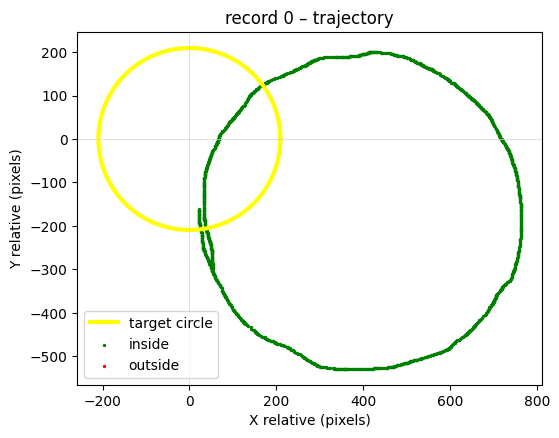

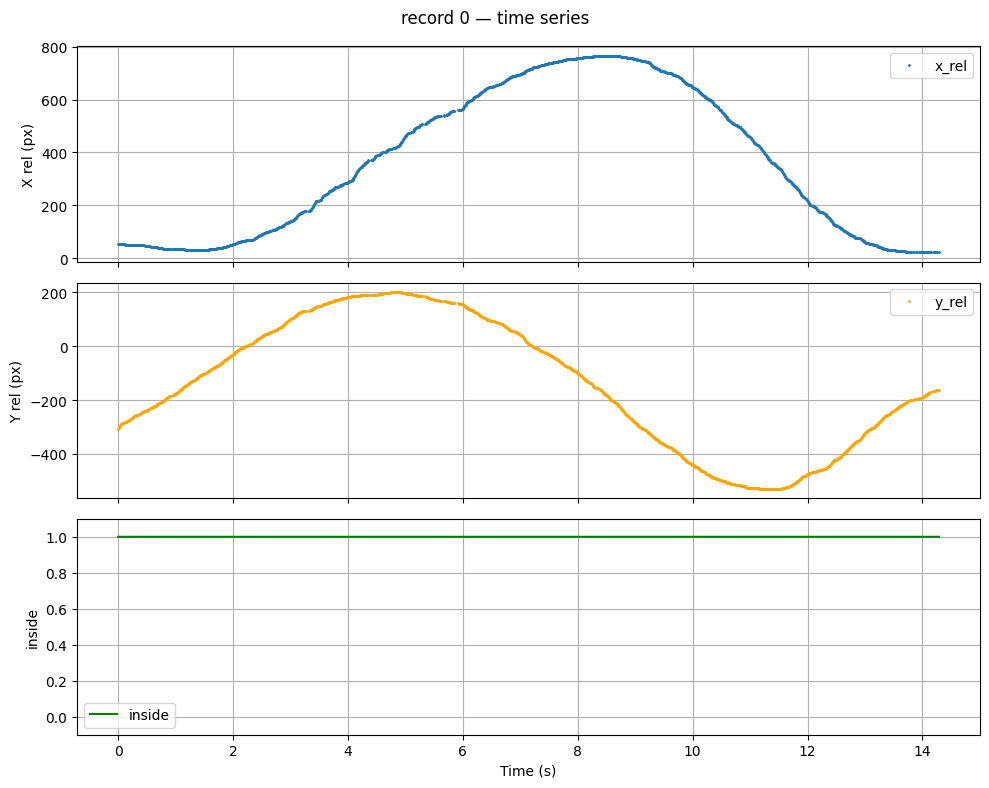

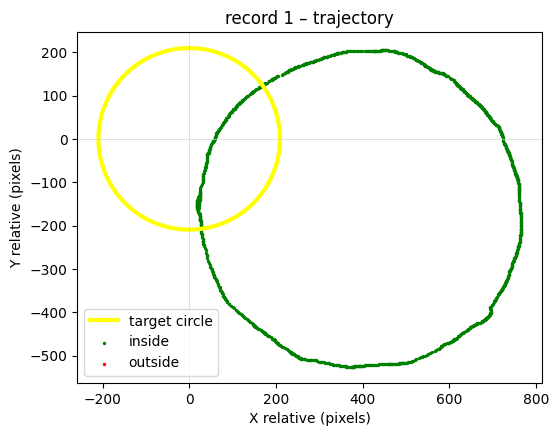

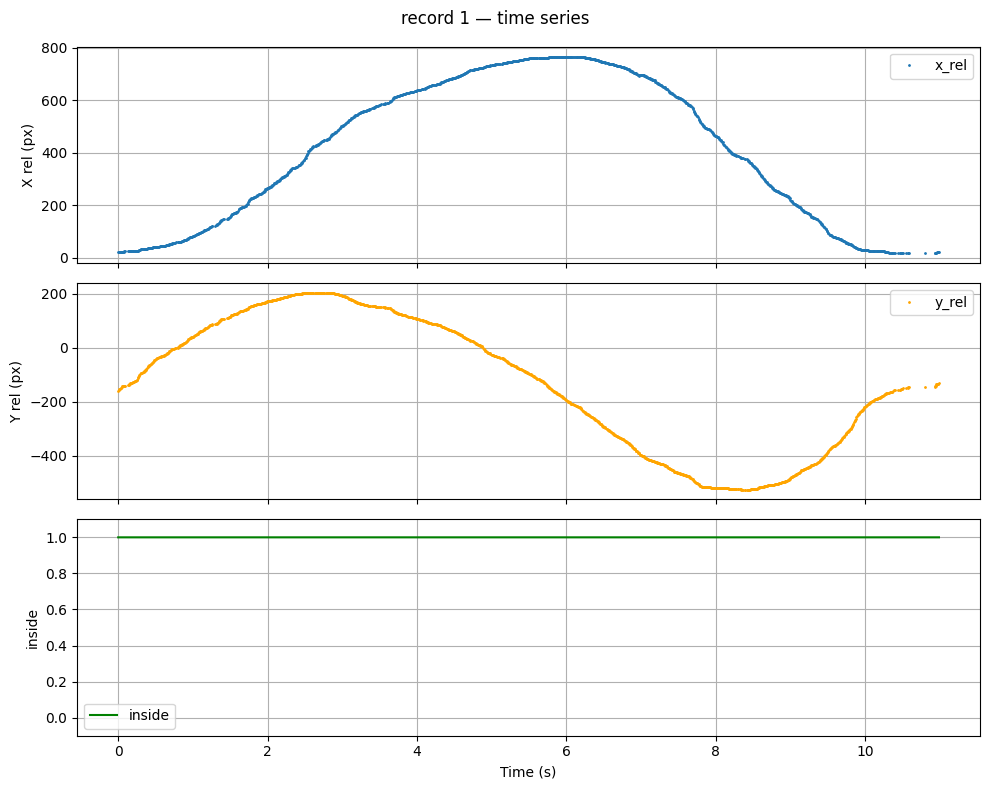

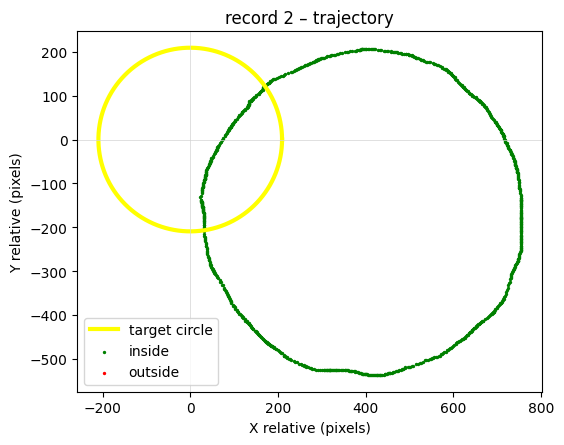

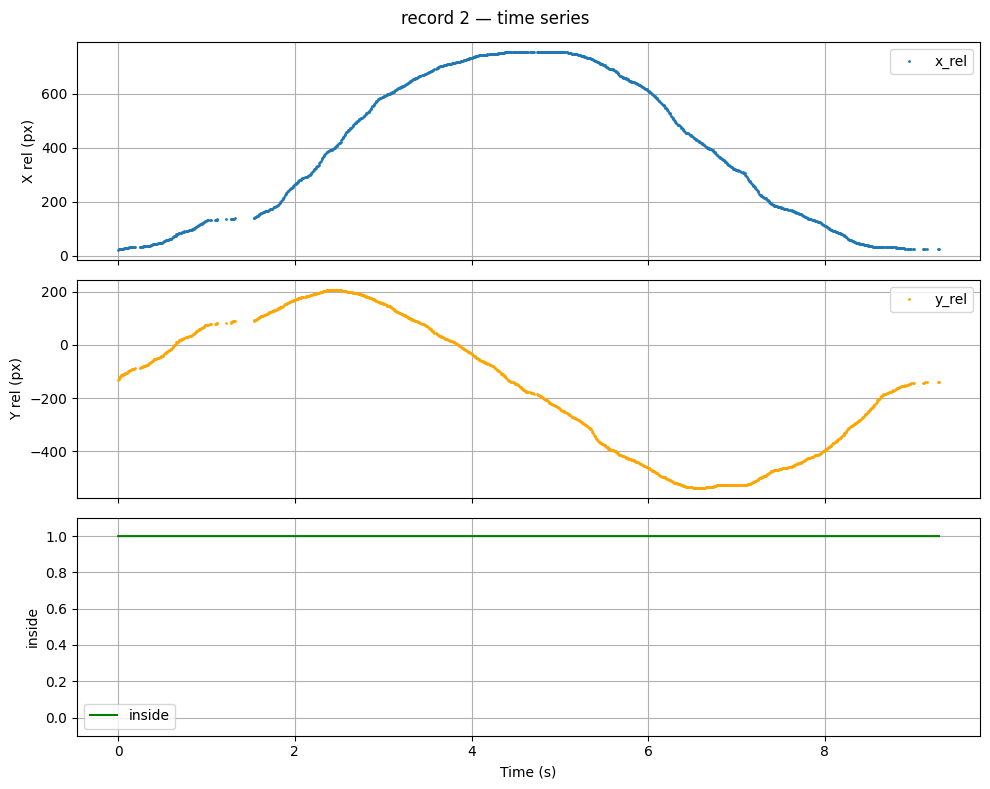


Recomputed metrics for MY data:

   Var ,   nLaps ,    Re ,    Te , error , MT/lap , IDe/lap ,   Be ,  IPe
Rec001 ,   0.01 ,  480.28 , 1030.20 ,   0.00 , 2668.72 ,    2.93 , 21.92 ,  0.00
Rec002 ,  -0.00 ,  516.22 , 1022.41 ,   0.00 , 3085.89 ,    3.17 , 21.75 ,  0.00
Rec003 ,  -0.00 ,  507.40 , 1013.19 ,   0.00 , 10057.19 ,    3.15 , 21.56 ,  0.00
Rec004 ,   0.00 ,  499.25 , 1020.66 ,   0.00 , 22071.51 ,    3.07 , 21.72 ,  0.00
Rec005 ,   0.02 ,  544.72 ,  905.25 ,   0.00 ,  284.19 ,    3.78 , 19.26 ,  0.01
Rec006 ,  -0.02 ,  506.64 ,  967.21 ,   4.52 ,  373.20 ,    3.29 , 20.58 ,  0.01


In [9]:
# --- Own kinematic data + markers using the SAME loaders ---

ts_ms_my, x_scr_my, y_scr_my, inside_my, meta_my = load_kinematic_data(MY_DATA_FILE)
starts_my, ends_my = load_record_markers(MY_MARKER_FILE)
record_ranges_my   = get_record_indices(ts_ms_my, starts_my, ends_my)

print("My data – number of records found:", len(record_ranges_my))
print("Index ranges:", record_ranges_my)

# --- Plot first 2–3 records of your own data ---
n_to_plot_my = min(3, len(record_ranges_my))

for rec_id in range(n_to_plot_my):
    s_idx, e_idx = record_ranges_my[rec_id]

    t_s, x_rel, y_rel, inside, xs, ys = extract_record(
        ts_ms_my, x_scr_my, y_scr_my, inside_my, s_idx, e_idx
    )

    plot_trajectory(rec_id, x_rel, y_rel, inside)
    plot_time_series(rec_id, t_s, x_rel, y_rel, inside)


# --- Recompute metrics for your own data (optional table) ---

print("\nRecomputed metrics for MY data:\n")
print("   Var ,   nLaps ,    Re ,    Te , error , MT/lap , IDe/lap ,   Be ,  IPe")

for i, (s_idx, e_idx) in enumerate(record_ranges_my, start=1):
    m = compute_metrics_for_record(ts_ms_my, x_scr_my, y_scr_my, inside_my, s_idx, e_idx)
    print(
        f"Rec{i:03d} , "
        f"{m['nLaps']:6.2f} , "
        f"{m['Re']:7.2f} , "
        f"{m['Te']:7.2f} , "
        f"{m['error%']:6.2f} , "
        f"{m['MT_lap']:7.2f} , "
        f"{m['IDe_lap']:7.2f} , "
        f"{m['Be']:5.2f} , "
        f"{m['IPe']:5.2f}"
    )